In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Create result directories
os.makedirs("results/predictions", exist_ok=True)
os.makedirs("results/loss_curves", exist_ok=True)
os.makedirs("results/optimizer_tests", exist_ok=True)


In [24]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_all = x_train_all.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Validation split
val_size = 6000
x_val = x_train_all[-val_size:]
y_val = y_train_all[-val_size:]

x_train = x_train_all[:-val_size]
y_train = y_train_all[:-val_size]

print(x_train.shape, x_val.shape, x_test.shape)


(54000, 28, 28) (6000, 28, 28) (10000, 28, 28)


In [25]:
base_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax")
])

base_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_base = base_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8651 - loss: 0.4788 - val_accuracy: 0.9633 - val_loss: 0.1322
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9580 - loss: 0.1493 - val_accuracy: 0.9697 - val_loss: 0.1081
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9707 - loss: 0.0978 - val_accuracy: 0.9725 - val_loss: 0.0963
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9793 - loss: 0.0708 - val_accuracy: 0.9760 - val_loss: 0.0848
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9831 - loss: 0.0566 - val_accuracy: 0.9778 - val_loss: 0.0844
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9873 - loss: 0.0422 - val_accuracy: 0.9800 - val_loss: 0.0794
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9891 - loss: 0.0353 - val_accuracy: 0.9807 - val_loss: 0.0749
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9919 - loss: 0.0295 - 

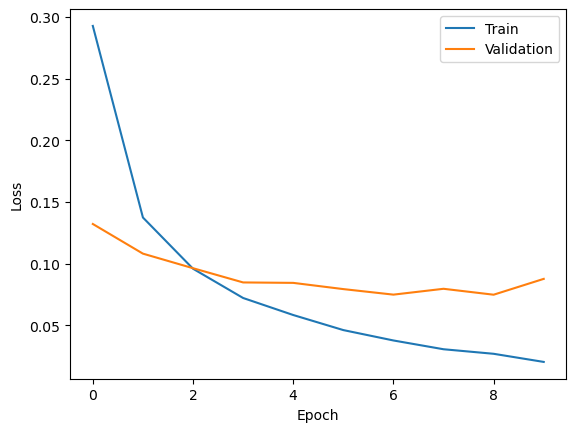

In [26]:
plt.plot(history_base.history["loss"], label="Train")
plt.plot(history_base.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("results/loss_curves/base_loss.png")
plt.show()


## **Task 1**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Index 4 | Predicted: 4 | True: 4


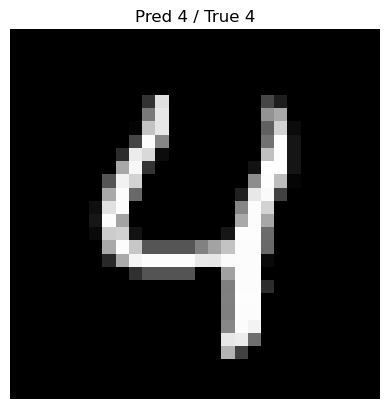

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Index 27 | Predicted: 4 | True: 4


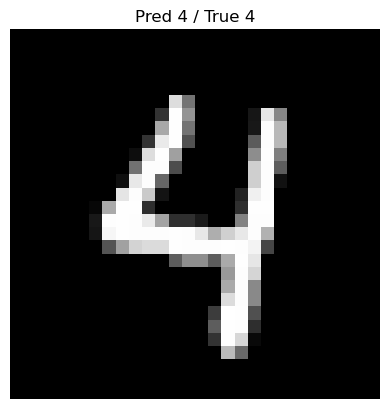

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Index 88 | Predicted: 6 | True: 6


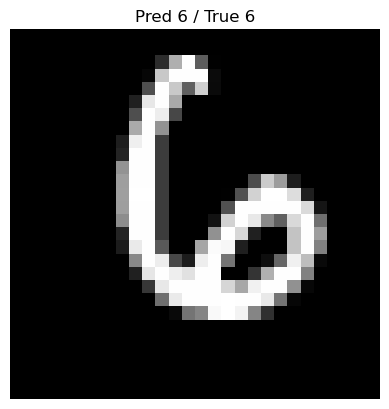

In [27]:
indices = [4, 27, 88]

for i in indices:
    sample = x_test[i].reshape(1, 28, 28)
    probs = base_model.predict(sample)
    pred = np.argmax(probs)

    print(f"Index {i} | Predicted: {pred} | True: {y_test[i]}")
    plt.imshow(x_test[i], cmap="gray")
    plt.title(f"Pred {pred} / True {y_test[i]}")
    plt.axis("off")
    plt.savefig(f"results/predictions/sample_{i}.png")
    plt.show()


## **Task 2 __ Custom Image Test**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Custom Image Prediction: 5


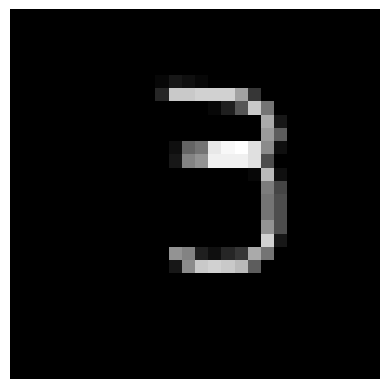

In [31]:
# Place a file named custom_digit.png in project root
if os.path.exists("custom_digit.png"):
    img = Image.open("custom_digit.png").convert("L")
    img = img.resize((28, 28))
    img_arr = np.array(img) / 255.0
    img_arr = img_arr.reshape(1, 28, 28)

    pred = base_model.predict(img_arr)
    print("Custom Image Prediction:", pred.argmax())

    plt.imshow(img_arr[0], cmap="gray")
    plt.axis("off")
    plt.savefig("results/predictions/custom_digit.png")
    plt.show()


## **Task 3 __ Epoch Comparison**

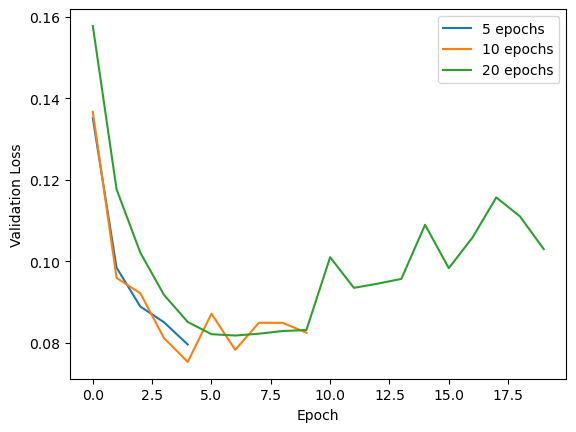

In [29]:
epoch_settings = [5, 10, 20]
epoch_histories = {}

for e in epoch_settings:
    model = models.clone_model(base_model)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    epoch_histories[e] = model.fit(
        x_train, y_train,
        epochs=e,
        validation_data=(x_val, y_val),
        verbose=0
    )

for e in epoch_settings:
    plt.plot(epoch_histories[e].history["val_loss"], label=f"{e} epochs")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig("results/loss_curves/epoch_comparison.png")
plt.show()


## **Task 4 __ Early Stopping**

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model_es = models.clone_model(base_model)
model_es.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

history_es = model_es.fit(
    x_train, y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8578 - loss: 0.4950 - val_accuracy: 0.9633 - val_loss: 0.1377
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9581 - loss: 0.1413 - val_accuracy: 0.9708 - val_loss: 0.1065
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9719 - loss: 0.0978 - val_accuracy: 0.9733 - val_loss: 0.0873
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9788 - loss: 0.0726 - val_accuracy: 0.9767 - val_loss: 0.0840
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9818 - loss: 0.0588 - val_accuracy: 0.9767 - val_loss: 0.0905
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9876 - loss: 0.0425 - val_accuracy: 0.9765 - val_loss: 0.0829
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9889 - loss: 0.0345 - val_accuracy: 0.9777 - val_loss: 0.0783
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9904 - loss: 0.0291 - 

## **TASK 5 — Dropout Ablation**

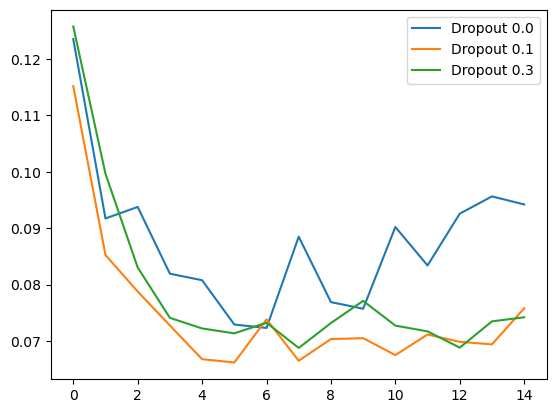

In [32]:
dropout_rates = [0.0, 0.1, 0.3]

for d in dropout_rates:
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(d),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(
        x_train, y_train,
        epochs=15,
        validation_data=(x_val, y_val),
        verbose=0
    )
    plt.plot(history.history["val_loss"], label=f"Dropout {d}")

plt.legend()
plt.savefig("results/loss_curves/dropout_comparison.png")
plt.show()


## **TASK 6 — L2 Regularization**

In [33]:
l2_values = [0.0001, 0.001, 0.01]

for l2v in l2_values:
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(l2v)),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    model.fit(
        x_train, y_train,
        epochs=15,
        validation_data=(x_val, y_val),
        verbose=0
    )


## **TASK 7 — Optimizer Comparison**

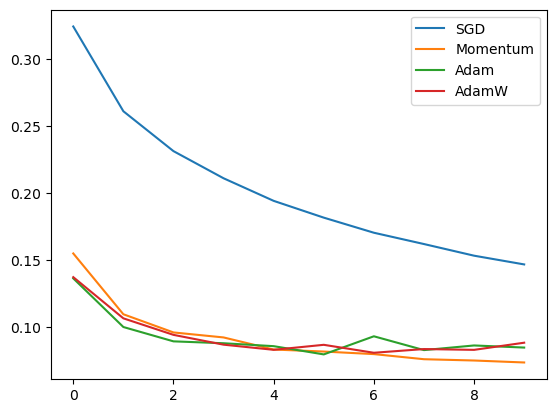

In [34]:
optimizers = {
    "SGD": tf.keras.optimizers.SGD(0.01),
    "Momentum": tf.keras.optimizers.SGD(0.01, momentum=0.9),
    "Adam": tf.keras.optimizers.Adam(),
    "AdamW": tf.keras.optimizers.AdamW()
}

for name, opt in optimizers.items():
    model = models.clone_model(base_model)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(
        x_train, y_train,
        epochs=10,
        validation_data=(x_val, y_val),
        verbose=0
    )
    plt.plot(history.history["val_loss"], label=name)

plt.legend()
plt.savefig("results/optimizer_tests/optimizer_comparison.png")
plt.show()


## **TASK 8 — Batch Size Experiment**

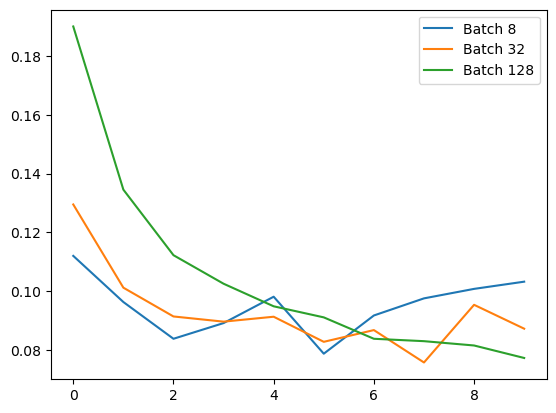

In [35]:
batch_sizes = [8, 32, 128]

for bs in batch_sizes:
    model = models.clone_model(base_model)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    history = model.fit(
        x_train, y_train,
        epochs=10,
        batch_size=bs,
        validation_data=(x_val, y_val),
        verbose=0
    )
    plt.plot(history.history["val_loss"], label=f"Batch {bs}")

plt.legend()
plt.savefig("results/loss_curves/batchsize_comparison.png")
plt.show()


## **TASK 9 — Activation Functions**

In [36]:
activations = ["tanh", "softsign", tf.keras.activations.gelu]

for act in activations:
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation=act),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    model.fit(
        x_train, y_train,
        epochs=10,
        validation_data=(x_val, y_val),
        verbose=0
    )


## **TASK 10 — Weight Inspection**

In [37]:
weights, bias = base_model.layers[1].get_weights()
print("Weight matrix shape:", weights.shape)


Weight matrix shape: (784, 96)


## **FINAL TEST EVALUATION**

In [38]:
test_loss, test_acc = base_model.evaluate(x_test, y_test)
print("Final Test Accuracy:", test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9708 - loss: 0.1103
Final Test Accuracy: 0.9753000140190125
